In [16]:
import cv2 as cv
from glob import glob
from ultralytics import YOLO
import easyocr

In [3]:
## if training on custom data is needed ##
#dataset = 'data/label_test2.yaml'
#backbone = YOLO("yolov8s.pt")  # load a pre-trained model (recommended for training)
#results_train = backbone.train(data=dataset, epochs=120,name='label_test2')

In [17]:
rl_model = YOLO('models/best.pt')

videos = glob('data/video/*.mp4')


In [18]:
reader = easyocr.Reader(['en'], gpu=True)

In [19]:
def read_label_digits(label_crop):
    detections = reader.readtext(label_crop, allowlist ='0123456789')
    for detection in detections:
        bbox, text, score = detection

        text = text.upper().replace(' ', '')
        return text, score

    return None, None

In [11]:
def write_csv(results, output_path):
    
    with open(output_path, 'w') as f:
        f.write('{},{},{},{},{},{}\n'.format(
            'frame_number', 'track_id', 'label_bbox', 'label_bbox_score', 'read_label',
            'text_score'))

        for frame_number in results.keys():
            for track_id in results[frame_number].keys():
                if 'label' in results[frame_number][track_id].keys() and \
                   'read_label' in results[frame_number][track_id]['label'].keys():
                    f.write('{},{},{},{},{},{}\n'.format(
                        frame_number,
                        track_id,
                        '[{} {} {} {}]'.format(
                            results[frame_number][track_id]['label']['bbox'][0],
                            results[frame_number][track_id]['label']['bbox'][1],
                            results[frame_number][track_id]['label']['bbox'][2],
                            results[frame_number][track_id]['label']['bbox'][3]
                        ),
                        results[frame_number][track_id]['label']['bbox_score'],
                        results[frame_number][track_id]['label']['read_label'],
                        results[frame_number][track_id]['label']['text_score'])
                    )
        f.close()

In [28]:
results = {}
video = cv.VideoCapture(videos[0])
ret = True
frame_number = -1
# get video dims
frame_width = int(video.get(3))
frame_height = int(video.get(4))
size = (frame_width, frame_height)

# Define the codec and create VideoWriter object
fourcc = cv.VideoWriter_fourcc(*'DIVX')
out = cv.VideoWriter('./outputs/processed.avi', fourcc, 20.0, size)

while ret:
    frame_number += 1
    ret, frame = video.read()

    if ret and frame_number < 1300:
        results[frame_number] = {}
        # label detector
        detections = rl_model.track(frame, persist=True,verbose=False)[0]
        for detection in detections.boxes.data.tolist():
            if len(detection)<7:
                continue
            else:
                x1, y1, x2, y2, track_id, score, _ = detection
                if score > 0.5:
                    label_bounding_boxes = []
                    label_bounding_boxes.append([x1, y1, x2, y2, track_id, score])
                    # process label
                    for label in label_bounding_boxes:
                        label_x1, label_y1, label_x2, label_y2,_ ,label_score = label
                        # crop label from region of interest
                        crop_label = frame[int(label_y1):int(label_y2), int(label_x1):int(label_x2)]
                        # enlarge and make digits clearer
                        gray = cv.cvtColor(cv.resize(crop_label,(0,0),fx=5,fy=5,interpolation=cv.INTER_CUBIC), cv.COLOR_BGR2GRAY)
                        label_thresh = cv.adaptiveThreshold(cv.medianBlur(gray, 7), 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)
    
                        cv.imwrite('./outputs/images/'+str(frame_number) + '_to_read.jpg', label_thresh)
                        # OCR
                        rl_text, rl_score = read_label_digits(label_thresh)
    
                        # if a label was read write results and 
                        if rl_text is not None:
                            results[frame_number][track_id] = {
                                'label': {
                                    'bbox': [label_x1, label_y1, label_x2, label_y2],
                                    'bbox_score': label_score,
                                    'read_label': rl_text,
                                    'text_score': rl_score}}
                            frame_out=frame
                            cv.rectangle(frame_out, (int(label_x1), int(label_y1)), (int(label_x2), int(label_y2)), (0, 0, 255), 6)

                            # write detected number
                            (text_width, text_height), _ = cv.getTextSize(rl_text, cv.FONT_HERSHEY_SIMPLEX, 2, 6)
                
                            cv.putText(frame_out, rl_text, (int((label_x2 + label_x1 - text_width)/2), int(label_y1 - text_height)), cv.FONT_HERSHEY_SIMPLEX,
                                2, (0, 255, 0), 6)

                            
                            frame_out = cv.resize(frame_out, size)
                            out.write(frame_out)

out.release()


#write_csv(results, './results.csv')
video.release()

0 (25, 57, 3)
1 (23, 55, 3)
2 (23, 55, 3)
3 (25, 57, 3)
3 (20, 30, 3)
4 (25, 58, 3)
5 (23, 53, 3)
6 (30, 53, 3)
6 (26, 56, 3)
7 (30, 55, 3)
7 (25, 58, 3)
8 (32, 57, 3)
8 (25, 55, 3)
9 (31, 55, 3)
9 (25, 53, 3)
10 (31, 54, 3)
10 (25, 58, 3)
11 (32, 57, 3)
11 (26, 57, 3)
11 (34, 88, 3)
12 (31, 54, 3)
12 (26, 53, 3)
12 (34, 85, 3)
13 (31, 54, 3)
13 (36, 89, 3)
13 (26, 58, 3)
14 (32, 57, 3)
14 (26, 54, 3)
14 (34, 87, 3)
15 (35, 86, 3)
15 (30, 52, 3)
15 (24, 53, 3)
16 (35, 87, 3)
16 (31, 53, 3)
16 (23, 55, 3)
17 (35, 58, 3)
17 (35, 86, 3)
17 (26, 52, 3)
17 (66, 71, 3)
18 (36, 86, 3)
18 (33, 53, 3)
18 (25, 56, 3)
19 (31, 52, 3)
19 (35, 85, 3)
19 (25, 55, 3)
19 (66, 73, 3)
20 (32, 55, 3)
20 (33, 85, 3)
20 (24, 54, 3)
21 (27, 57, 3)
21 (34, 85, 3)
21 (31, 50, 3)
21 (64, 76, 3)
22 (26, 56, 3)
22 (36, 82, 3)
22 (28, 55, 3)
22 (63, 71, 3)
23 (26, 57, 3)
23 (31, 51, 3)
23 (38, 84, 3)
23 (62, 71, 3)
24 (25, 53, 3)
24 (37, 82, 3)
24 (28, 52, 3)
24 (64, 75, 3)
25 (30, 52, 3)
25 (28, 55, 3)
25 (36, 81

59


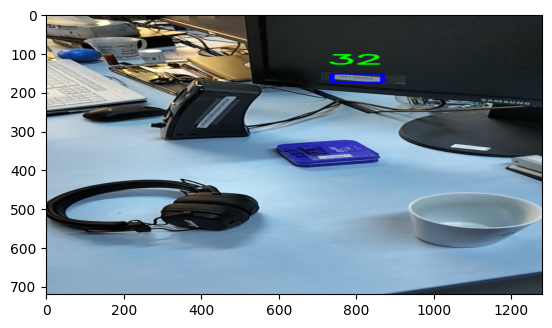

In [27]:
from matplotlib import pyplot as plt
print(frame_number)
plt.imshow(frame)